In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

import pickle
import os
import pandas as pd
import json

import glob

In [2]:
TIMESTAMP_DECIMALS = 2
TIME_DELTA = 0.01
RESAMPLE_STRATEGY = "MEAN" # "FILL" 
### MEAN: Resample using pandas' resample, fill holes with linear interpolation
### FILL: Round timestamps to closest 0.01s bucket, drop duplicate timestamps, fill holes with forward fillx


# PATHS
reference_data_path_some_failed_some_succeeded = "./post_recorded_reference_data/Build/Some_Failed_Some_Succeeded"
reference_data_path_all_failed = "./post_recorded_reference_data/Build/All_Failed"
some_failed_save_path = "./post_recorded_reference_data/reference_some_events_failed.pickle"
all_failed_save_path = "./post_recorded_reference_data/reference_all_events_failed.pickle"

In [3]:
#### Description of the processing 
'''
The reference files are loaded and saved in seperate dataframes in seperate dictionaries. 
The scenedata files are used to extract the event start and stop timestamps. 
The input files contain the car position and rotation data.
Those input files are used to extract path segments that are not events. 
Using the timestamps from the scenedata files, the segments are labeled from 0 to 3;
the datapoints that belong to events are -9. 
The segments are extracted and stored seperately within the input files dictionary. 
The segments timestamps are rebased based on the last event's stop timestamp (or for first segment to 0).

Resampling: 
Since the existing data (without car world coordinates) and the new data need to be synched somehow,
datapoints' timestamps are rounded to 0.01s seconds. 
Additionally, missing holes are filled with linearly interpolated values. 
The 0.01s time delta is also useful as proper timeseries data for the model. 

Convenience Dictionary:
For convenient access of the reference paths.
'''

"\nThe reference files are loaded and saved in seperate dataframes in seperate dictionaries. \nThe scenedata files are used to extract the event start and stop timestamps. \nThe input files contain the car position and rotation data.\nThose input files are used to extract path segments that are not events. \nUsing the timestamps from the scenedata files, the segments are labeled from 0 to 3;\nthe datapoints that belong to events are -9. \nThe segments are extracted and stored seperately within the input files dictionary. \nThe segments timestamps are rebased based on the last event's stop timestamp (or for first segment to 0).\n\nResampling: \nSince the existing data (without car world coordinates) and the new data need to be synched somehow,\ndatapoints' timestamps are rounded to 0.01s seconds. \nAdditionally, missing holes are filled with linearly interpolated values. \nThe 0.01s time delta is also useful as proper timeseries data for the model. \n\nConvenience Dictionary:\nFor conve

In [4]:
def read_normalized_json_to_df(filepath):
    full_file_df = ""
    with open(filepath, 'r', encoding="utf-8") as json_file:
        json_full = json.load(json_file)
    full_file_df = pd.json_normalize(json_full)
    return full_file_df
def save_to_disk(data, filepath):
    with open(filepath, 'wb') as file:
        pickle.dump(data, file)
def load_from_disk(filepath):
    with open(filepath, 'rb') as file:
        data = pickle.load(file)
        return data

In [5]:
def _read_raw_car_reference_files(reference_data_path):

    print("\nTotal number of reference files: " + str(len(os.listdir(reference_data_path)))) 
    print("Path: " + reference_data_path)
    
    # Check if reference files were processed before 
    if (os.path.isfile(os.path.join(reference_data_path, "combined_reference_data.pickle"))):
        print("Loading previously processed reference files...")
        combined_ref_data = load_from_disk(os.path.join(reference_data_path, "combined_reference_data.pickle"))
        reference_input_files = combined_ref_data["reference_input_files"] 
        reference_eyetracking_files = combined_ref_data["reference_eyetracking_files"] 
        reference_scenedata_files = combined_ref_data["reference_scenedata_files"]
        reference_data_files_path = combined_ref_data["reference_data_files_path"]
        reference_participant_calibration_file = combined_ref_data["reference_participant_calibration_file"]
        print("Files were initially processed from path: " + reference_data_files_path)
        print("Finished loading reference files.")
    
    # Read raw post recorded reference data 
    else:
        print("Loading raw reference files...")
        reference_input_files = {}
        reference_eyetracking_files = {}
        reference_scenedata_files = {}
        reference_participant_calibration_file = {}
        reference_participant_calibration_file['filename'] = glob.glob(reference_data_path + "/*ParticipantCalibrationData.txt")[0]
        reference_participant_calibration_file['full_df'] = read_normalized_json_to_df(glob.glob(reference_data_path + "/*ParticipantCalibrationData.txt")[0])
        for filename in glob.glob(reference_data_path + "/*_Input*.txt"):
            if "Westbrueck" in filename:
                token = "Westbrueck"
            elif "MountainRoad" in filename:
                token = "MountainRoad"
            elif "CountryRoad" in filename:
                token = "CountryRoad"
            elif "Autobahn" in filename:
                token = "Autobahn"
            else:  # not defined 
                continue # in the loop 
            reference_input_files[token] = {}
            reference_input_files[token]["filename"] = filename
            reference_input_files[token]["full_df"] = read_normalized_json_to_df(filename)
        for filename in glob.glob(reference_data_path + "/*_EyeTracking*.txt"):
            if "Westbrueck" in filename:
                token = "Westbrueck"
            elif "MountainRoad" in filename:
                token = "MountainRoad"
            elif "CountryRoad" in filename:
                token = "CountryRoad"
            elif "Autobahn" in filename:
                token = "Autobahn"  
            else:  # not defined 
                continue # in the loop     
            reference_eyetracking_files[token] = {}
            reference_eyetracking_files[token]["filename"] = filename
            reference_eyetracking_files[token]["full_df"] = read_normalized_json_to_df(filename)
        for filename in glob.glob(reference_data_path + "/*_SceneData*.txt"): 
            if "Westbrueck" in filename:
                token = "Westbrueck"
            elif "MountainRoad" in filename:
                token = "MountainRoad"
            elif "CountryRoad" in filename:
                token = "CountryRoad"
            elif "Autobahn" in filename:
                token = "Autobahn"     
            else:  # not defined 
                continue # in the loop  
            reference_scenedata_files[token] = {}
            reference_scenedata_files[token]["filename"] = filename
            reference_scenedata_files[token]["full_df"] = read_normalized_json_to_df(filename)

        # Save processed reference files 
        print("Finished loading reference files.")
        print("Saving combined reference data to disk...")
        combined_ref_data = {}
        combined_ref_data["reference_data_files_path"] = reference_data_path
        combined_ref_data["reference_input_files"] = reference_input_files
        combined_ref_data["reference_eyetracking_files"] = reference_eyetracking_files
        combined_ref_data["reference_scenedata_files"] = reference_scenedata_files
        combined_ref_data["reference_participant_calibration_file"] = reference_participant_calibration_file
        save_to_disk(combined_ref_data, os.path.join(reference_data_path, "combined_reference_data.pickle"))
        print("Finished saving combined reference data to disk.")
    
    return reference_input_files, reference_eyetracking_files, reference_scenedata_files, reference_participant_calibration_file

In [6]:
def _extract_event_information(reference_data_path):
    
    # load raw files 
    reference_input_files, reference_eyetracking_files, reference_scenedata_files, reference_participant_calibration_file = _read_raw_car_reference_files(reference_data_path)
    
    
    # Extract most important event information 
    for area in ["Westbrueck","MountainRoad","CountryRoad","Autobahn"]:
        reference_scenedata_files[area]["number_of_events"] = len(reference_scenedata_files[area]["full_df"]["EventBehavior"][0])
        reference_scenedata_files[area]["events"] = {}
        for idx, event in enumerate(reference_scenedata_files[area]["full_df"]["EventBehavior"][0]):
            reference_scenedata_files[area]["events"][idx] = {'name':event["EventName"],'start':event["StartofEventTimeStamp"],'stop':event["EndOfEventTimeStamp"],'succeeded':event["SuccessfulCompletionState"]}
                
    return reference_input_files, reference_eyetracking_files, reference_scenedata_files, reference_participant_calibration_file

In [7]:
def _extract_path_segments(reference_data_path):
    
    # extract event information
    reference_input_files, reference_eyetracking_files, reference_scenedata_files, reference_participant_calibration_file = _extract_event_information(reference_data_path)
    
    
    # Copy of entire dataframe input dataframe to prepare processing
    for area in ["Westbrueck","MountainRoad","CountryRoad","Autobahn"]:
        reference_input_files[area]["processed_df"] = reference_input_files[area]["full_df"].copy(deep=True)
        reference_input_files[area]["processed_df"].drop(columns=["ReceivedInput","SteeringInput","AcellerationInput","BrakeInput"],inplace=True)
        reference_input_files[area]["processed_df"]["path_segment_label"] = -9 # event label 

    # Give label to individual path segments, -9 is event label 
    for area in ["Westbrueck","MountainRoad","CountryRoad","Autobahn"]:
        for event_idx in range(len(reference_scenedata_files[area]["events"]) + 1):
            cond = None 
            if event_idx == 0: # find all datapoints with timestamps before event start timestamp 
                cond = (reference_input_files[area]["processed_df"]["TimeStamp"] < reference_scenedata_files[area]["events"][event_idx]["start"])
            elif event_idx < len(reference_scenedata_files[area]["events"]): # find all datapoints with timestamp between prev and next event 
                cond = (reference_input_files[area]["processed_df"]["TimeStamp"] > reference_scenedata_files[area]["events"][event_idx - 1]["stop"]) & (reference_input_files[area]["processed_df"]["TimeStamp"] < reference_scenedata_files[area]["events"][event_idx]["start"])
            elif event_idx == len(reference_scenedata_files[area]["events"]): # find all datapoints with timestamp after last event
                cond = (reference_input_files[area]["processed_df"]["TimeStamp"] > reference_scenedata_files[area]["events"][event_idx - 1]["stop"])

            # Filter     
            reference_input_files[area]["processed_df"].loc[cond, "path_segment_label"] = event_idx

    # Extract path segments, add timestamps beginning at zero 
    for area in ["Westbrueck","MountainRoad","CountryRoad","Autobahn"]:
        reference_input_files[area]["path_segments_no_resample"] = {}
        for label in reference_input_files[area]["processed_df"]["path_segment_label"].unique():
            if (label != -9):

                # copy segment data 
                cond = (reference_input_files[area]["processed_df"]["path_segment_label"] == label)
                reference_input_files[area]["path_segments_no_resample"][label] = reference_input_files[area]["processed_df"].loc[cond].copy(deep=True)

                # add timestamp starting at zero 
                if label == 0: # take first recorded datapoint as base timestamp 
                    ref_timestamp = reference_input_files[area]["path_segments_no_resample"][label]["TimeStamp"].iloc[0]
                else: # take last event's stop time as base timestamp 
                    ref_timestamp = reference_scenedata_files[area]["events"][label - 1]["stop"]

                reference_input_files[area]["path_segments_no_resample"][label]["rebased_timestamp"] = reference_input_files[area]["path_segments_no_resample"][label]["TimeStamp"] - ref_timestamp

            else: # skip events 
                pass 
    
    return reference_input_files, reference_eyetracking_files, reference_scenedata_files, reference_participant_calibration_file

In [8]:
# Resample path segments 

def _resample_reference_path_segments(reference_data_path):

    # extract path segments
    reference_input_files, reference_eyetracking_files, reference_scenedata_files, reference_participant_calibration_file = _extract_path_segments(reference_data_path)
    
    print("Resampled path segments (excl. events):")
    for area in ["Westbrueck","MountainRoad","CountryRoad","Autobahn"]:

        reference_input_files[area]["path_segments_resampled"] = {}
        for segment in reference_input_files[area]["path_segments_no_resample"]:
            # copy segments 
            reference_input_files[area]["path_segments_resampled"][segment] = reference_input_files[area]["path_segments_no_resample"][segment].copy(deep=True)

            # Hard match datapoints to closest timebin and fill arising holes by forward fill 
            if RESAMPLE_STRATEGY == "FILL":

                # round the timestamps to specified number of decimals 
                reference_input_files[area]["path_segments_resampled"][segment]["rebased_timestamp_rounded"] = reference_input_files[area]["path_segments_resampled"][segment]["rebased_timestamp"].round(TIMESTAMP_DECIMALS)

                # "resample" timestamps by reindexing with time delta (default 0.01s) steps and filling holes; first drop duplicate timestamps
                reference_input_files[area]["path_segments_resampled"][segment]["resampled_timestamp"] = reference_input_files[area]["path_segments_resampled"][segment]["rebased_timestamp_rounded"] 
                reference_input_files[area]["path_segments_resampled"][segment].drop_duplicates(subset="resampled_timestamp",keep="first", inplace=True)
                start_time = 0
                end_time = reference_input_files[area]["path_segments_resampled"][segment]["resampled_timestamp"].iloc[-1]
                time_delta = TIME_DELTA
                new_index = pd.Index(np.arange(start_time,end_time,time_delta), name="resampled_timestamp")
                reference_input_files[area]["path_segments_resampled"][segment] = reference_input_files[area]["path_segments_resampled"][segment].set_index("resampled_timestamp").reindex(new_index).reset_index()

                # keep track of where data was interpolated 
                reference_input_files[area]["path_segments_resampled"][segment]["is_interpolated"] = reference_input_files[area]["path_segments_resampled"][segment]["rebased_timestamp"].isnull()

                # fill nans ("interpolate") 
                exclude_columns = ["rebased_timestamp","rebased_timestamp_rounded","is_interpolated","TimeStamp","resampled_timestamp"]
                for column in reference_input_files[area]["path_segments_resampled"][segment].columns:  
                    if column not in exclude_columns:
                        reference_input_files[area]["path_segments_resampled"][segment][column].fillna(method='ffill', inplace = True)
                        reference_input_files[area]["path_segments_resampled"][segment][column].fillna(method='bfill', inplace = True)

                # drop unneeded columns
                reference_input_files[area]["path_segments_resampled"][segment].drop(columns=["TimeStamp","rebased_timestamp","rebased_timestamp_rounded","path_segment_label"], inplace = True)


            # Resample using pandas' resample, fill with mean 
            if RESAMPLE_STRATEGY == "MEAN":

                # copy timestamp 
                reference_input_files[area]["path_segments_resampled"][segment]["resampled_timestamp"] = reference_input_files[area]["path_segments_resampled"][segment]["rebased_timestamp"] 

                # create datetime from rebased timestamp
                reference_input_files[area]["path_segments_resampled"][segment]["rebased_datetime"] = pd.to_datetime(reference_input_files[area]["path_segments_resampled"][segment]['resampled_timestamp'],unit='s')

                # resample with time delta (default 0.01s) interval and keep track of holes in the data before interpolation
                reference_input_files[area]["path_segments_resampled"][segment] = reference_input_files[area]["path_segments_resampled"][segment].resample(str(TIME_DELTA) + 'S',on="rebased_datetime").mean()
                reference_input_files[area]["path_segments_resampled"][segment]["is_interpolated"] = reference_input_files[area]["path_segments_resampled"][segment]["resampled_timestamp"].isnull()
                reference_input_files[area]["path_segments_resampled"][segment].reset_index(inplace=True)

                # interpolate linearly
                reference_input_files[area]["path_segments_resampled"][segment].interpolate(method="linear",inplace=True)

                # get resampled_timestamp from rebased_datetime again 
                reference_input_files[area]["path_segments_resampled"][segment]["resampled_timestamp"] = (reference_input_files[area]["path_segments_resampled"][segment]["rebased_datetime"] - pd.Timestamp("1970-01-01")) / pd.Timedelta('1s')

                # drop unneeded columns
                reference_input_files[area]["path_segments_resampled"][segment].drop(columns=["rebased_datetime","TimeStamp","rebased_timestamp","path_segment_label"], inplace = True)


            print("Area: " + area + " Segment: " + str(segment) + " Total datapoints (incl. resampled): " + str(len(reference_input_files[area]["path_segments_resampled"][segment]["is_interpolated"]))  + " Filled NaNs: " + str(reference_input_files[area]["path_segments_resampled"][segment]["is_interpolated"].values.sum()))

            
    
    return reference_input_files, reference_eyetracking_files, reference_scenedata_files, reference_participant_calibration_file

In [9]:
def generate_reference_paths(reference_data_path):
    
    # get resampled path segments
    reference_input_files, reference_eyetracking_files, reference_scenedata_files, reference_participant_calibration_file = _resample_reference_path_segments(reference_data_path)
    
    # extract most important infos
    reference_paths = {}
    for area in ["Westbrueck","MountainRoad","CountryRoad","Autobahn"]:
        reference_paths[area] = {}
        for segment in reference_input_files[area]["path_segments_resampled"]:
            reference_paths[area][segment] = reference_input_files[area]["path_segments_resampled"][segment].copy(deep = True)
            #reference_paths[area][segment].drop(columns=["path_segment_label","rebased_timestamp","rebased_timestamp_rounded"],inplace=True)
    
    # extract event infos 
    event_info = {}
    for area in ["Westbrueck","MountainRoad","CountryRoad","Autobahn"]:
        event_info[area] = {}
        for event in reference_scenedata_files[area]["events"]:
            event_info[area][event] = {}
            event_info[area][event]['name'] = reference_scenedata_files[area]["events"][event]['name']
            event_info[area][event]['start'] = reference_scenedata_files[area]["events"][event]['start']
            event_info[area][event]['stop'] = reference_scenedata_files[area]["events"][event]['stop']
            event_info[area][event]['succeeded'] = reference_scenedata_files[area]["events"][event]['succeeded']
                        
    return reference_paths, event_info


In [10]:
# Generate the reference path cleaned data 
reference_paths_some_events_failed, event_info_some_events_failed = generate_reference_paths(reference_data_path_some_failed_some_succeeded)
reference_paths_all_events_failed, event_info_all_events_failed = generate_reference_paths(reference_data_path_all_failed)


Total number of reference files: 14
Path: ./post_recorded_reference_data/Build/Some_Failed_Some_Succeeded
Loading previously processed reference files...
Files were initially processed from path: ./post_recorded_reference_data/Build/Some_Failed_Some_Succeeded
Finished loading reference files.
Resampled path segments (excl. events):
Area: Westbrueck Segment: 0 Total datapoints (incl. resampled): 2459 Filled NaNs: 911
Area: Westbrueck Segment: 1 Total datapoints (incl. resampled): 2508 Filled NaNs: 917
Area: Westbrueck Segment: 2 Total datapoints (incl. resampled): 2372 Filled NaNs: 733
Area: Westbrueck Segment: 3 Total datapoints (incl. resampled): 2130 Filled NaNs: 624
Area: MountainRoad Segment: 0 Total datapoints (incl. resampled): 1995 Filled NaNs: 1029
Area: MountainRoad Segment: 1 Total datapoints (incl. resampled): 3685 Filled NaNs: 1708
Area: MountainRoad Segment: 2 Total datapoints (incl. resampled): 5253 Filled NaNs: 1865
Area: MountainRoad Segment: 3 Total datapoints (incl. 

In [11]:
# save generated data to disk 
save_to_disk(reference_paths_some_events_failed, some_failed_save_path)
save_to_disk(reference_paths_all_events_failed, all_failed_save_path)

In [12]:
# Check for nans in the data 
found_nans = False 
data_names = ["reference data with some events failed", "reference data with all events failed"]
print("Checking for NaNs...")
for idx, data in enumerate([reference_paths_some_events_failed, reference_paths_all_events_failed]):
    for area in ["Westbrueck", "MountainRoad","CountryRoad","Autobahn"]:
        for segment in data[area]:
            if(data[area][segment].isnull().any().any()):
                found_nans = True 
                print("Found NaNs in " + str(data_names[idx]) + ", area " + area + ", segment " + str(segment) + ":")
                print(data[area][segment][data[area][segment].isnull().any(axis=1)])
        
if (not found_nans):
    print("Finished, found no NaNs.")



Checking for NaNs...
Finished, found no NaNs.


In [13]:
#
# Data column for time series comparison 
data_comp_dict = {}

car_data_names = ["CarPosition.x","CarPosition.y","CarPosition.z","CarRotation.x","CarRotation.y","CarRotation.z"]
areas = ["Westbrueck", "MountainRoad","CountryRoad","Autobahn"]
segments = [0,1,2,3]

for idx in range(len(car_data_names)*len(areas)*len(segments)):
    car_data_idx = idx % len(car_data_names)
    segments_idx = (idx // len(car_data_names) ) % len(segments)
    area_idx = (idx // (len(car_data_names) * len(segments))) % len(areas)
    
    current_position_name = car_data_names[car_data_idx] + '_' + areas[area_idx] + '_segment_' + str(segments[segments_idx])
    all_length = len(reference_paths_all_events_failed[areas[area_idx]][segments_idx][car_data_names[car_data_idx]])
    some_length = len(reference_paths_some_events_failed[areas[area_idx]][segments_idx][car_data_names[car_data_idx]])
    
    
    if all_length > some_length:
        reference_path_all = reference_paths_all_events_failed[areas[area_idx]][segments_idx][car_data_names[car_data_idx]][:some_length]
        reference_path_some = reference_paths_some_events_failed[areas[area_idx]][segments_idx][car_data_names[car_data_idx]]
        
        data_comp_dict[current_position_name] = [np.corrcoef(reference_path_all, reference_path_some)[0,1]]
    else:
        reference_path_all = reference_paths_all_events_failed[areas[area_idx]][segments_idx][car_data_names[car_data_idx]]
        reference_path_some = reference_paths_some_events_failed[areas[area_idx]][segments_idx][car_data_names[car_data_idx]][:all_length]
        
        data_comp_dict[current_position_name] = [np.corrcoef(reference_path_all, reference_path_some)[0,1]]





/Applications/anaconda3/envs/Body2Eye/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Applications/anaconda3/envs/Body2Eye/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [29]:
#
# Data column for time series comparison 
data_comp_dict = {}

car_data_names = ["CarPosition.x","CarPosition.y","CarPosition.z","CarRotation.x","CarRotation.y","CarRotation.z"]
areas = ["Westbrueck", "MountainRoad","CountryRoad","Autobahn"]
segments = [0,1,2,3]

for idx in range(len(car_data_names)*len(areas)*len(segments)):
    car_data_idx = idx % len(car_data_names)
    segments_idx = (idx // len(car_data_names) ) % len(segments)
    area_idx = (idx // (len(car_data_names) * len(segments))) % len(areas)
    
    current_position_name = car_data_names[car_data_idx] + '_' + areas[area_idx] + '_segment_' + str(segments[segments_idx])
    all_length = len(reference_paths_all_events_failed[areas[area_idx]][segments_idx][car_data_names[car_data_idx]])
    some_length = len(reference_paths_some_events_failed[areas[area_idx]][segments_idx][car_data_names[car_data_idx]])
    
    
    if all_length > some_length:
        reference_path_all = reference_paths_all_events_failed[areas[area_idx]][segments_idx][car_data_names[car_data_idx]][all_length-some_length:]
        reference_path_some = reference_paths_some_events_failed[areas[area_idx]][segments_idx][car_data_names[car_data_idx]]
        
        data_comp_dict[current_position_name] = [np.corrcoef(reference_path_all, reference_path_some)[0,1]]
    else:
        reference_path_all = reference_paths_all_events_failed[areas[area_idx]][segments_idx][car_data_names[car_data_idx]]
        reference_path_some = reference_paths_some_events_failed[areas[area_idx]][segments_idx][car_data_names[car_data_idx]][some_length-all_length:]
        
        data_comp_dict[current_position_name] = [np.corrcoef(reference_path_all, reference_path_some)[0,1]]






In [19]:
#
# Data column for time series comparison 
data_comp_dict = {}

# Dict for new time intervals
reference_dict_all = dict()
reference_dict_some = dict() 

car_data_names = ["CarPosition.x","CarPosition.y","CarPosition.z","CarRotation.x","CarRotation.y","CarRotation.z"]
areas = ["Westbrueck", "MountainRoad","CountryRoad","Autobahn"]
segments = [0,1,2,3]

for idx in range(len(car_data_names)*len(areas)*len(segments)):
    car_data_idx = idx % len(car_data_names)
    segments_idx = (idx // len(car_data_names) ) % len(segments)
    area_idx = (idx // (len(car_data_names) * len(segments))) % len(areas)
    
    current_position_name = car_data_names[car_data_idx] + '_' + areas[area_idx] + '_segment_' + str(segments[segments_idx])
    all_length = len(reference_paths_all_events_failed[areas[area_idx]][segments_idx][car_data_names[car_data_idx]])
    some_length = len(reference_paths_some_events_failed[areas[area_idx]][segments_idx][car_data_names[car_data_idx]])
    
    
    
    if all_length > some_length:
        shift = all_length-some_length
        reference_path_all = reference_paths_all_events_failed[areas[area_idx]][segments_idx][car_data_names[car_data_idx]][round(all_length*0.1)+shift:]
        reference_path_some = reference_paths_some_events_failed[areas[area_idx]][segments_idx][car_data_names[car_data_idx]][round(all_length*0.1):]
        
        data_comp_dict[current_position_name] = [np.corrcoef(reference_path_all, reference_path_some)[0,1]]
        
        reference_dict_all[areas[area_idx]][segments_idx][car_data_names[car_data_idx]] = reference_path_all
        
        print(areas[area_idx] 
              + ', Segment: ' 
              + str(segments_idx) 
              + ', Car_Data: ' 
              + car_data_names[car_data_idx] 
              + ', Length: ' 
              + str(all_length) 
              + ', Shift:' 
              + str(shift)
              + ', Corr: '
              + "{0:.3f}".format(data_comp_dict[current_position_name][0]))
    else:
        shift = some_length-all_length
        reference_path_all = reference_paths_all_events_failed[areas[area_idx]][segments_idx][car_data_names[car_data_idx]][round(some_length*0.1):]
        reference_path_some = reference_paths_some_events_failed[areas[area_idx]][segments_idx][car_data_names[car_data_idx]][round(some_length*0.1)+shift:]
        
        data_comp_dict[current_position_name] = [np.corrcoef(reference_path_all, reference_path_some)[0,1]]


        print(areas[area_idx] 
              + ', Segment: ' 
              + str(segments_idx) 
              + ', Car_Data: ' 
              + car_data_names[car_data_idx] 
              + ', Length: ' 
              + str(some_length) 
              + ', Shift:' 
              + str(shift)
              + ', Corr: '
              + "{0:.3f}".format(data_comp_dict[current_position_name][0]))

Westbrueck, Segment: 0, Car_Data: CarPosition.x, Length: 2459, Shift:1, Corr: 1.000
Westbrueck, Segment: 0, Car_Data: CarPosition.y, Length: 2459, Shift:1, Corr: 1.000
Westbrueck, Segment: 0, Car_Data: CarPosition.z, Length: 2459, Shift:1, Corr: 1.000
Westbrueck, Segment: 0, Car_Data: CarRotation.x, Length: 2459, Shift:1, Corr: 0.999
Westbrueck, Segment: 0, Car_Data: CarRotation.y, Length: 2459, Shift:1, Corr: 1.000
Westbrueck, Segment: 0, Car_Data: CarRotation.z, Length: 2459, Shift:1, Corr: 0.980
Westbrueck, Segment: 1, Car_Data: CarPosition.x, Length: 2512, Shift:4, Corr: 1.000
Westbrueck, Segment: 1, Car_Data: CarPosition.y, Length: 2512, Shift:4, Corr: 1.000
Westbrueck, Segment: 1, Car_Data: CarPosition.z, Length: 2512, Shift:4, Corr: 1.000
Westbrueck, Segment: 1, Car_Data: CarRotation.x, Length: 2512, Shift:4, Corr: 0.992
Westbrueck, Segment: 1, Car_Data: CarRotation.y, Length: 2512, Shift:4, Corr: 1.000
Westbrueck, Segment: 1, Car_Data: CarRotation.z, Length: 2512, Shift:4, Corr

In [27]:
# Event info 
print("Event info")

#print("-- Some events failed, some succeeded -- \t -- All events failed --")
print("{0:30}{1}".format("-- Some events failed --","-- All events failed --"))
for area in ["Westbrueck", "MountainRoad","CountryRoad","Autobahn"]:
    print("{0:30}{1}".format(area,area))
    for segment in event_info_some_events_failed[area]:
        print("{0:5}{1:30}{2}".format("","Segment " + str(segment), "Segment " + str(segment)), "          Correlation (CarPos.X, CarRot.X): " + "{0:.4f}".format(data_comp_dict["CarPosition.x_" + area + "_segment_" + str(segment)][0]), ", ", "{0:.4f}".format(data_comp_dict["CarRotation.x_" + area + "_segment_" + str(segment)][0]))
        print("{0:5}{1:30}{2}".format("","Event: " + ("Succeeded" if event_info_some_events_failed[area][segment]["succeeded"] == True else "Failed"), "Event: " + ("Succeeded" if event_info_all_events_failed[area][segment]["succeeded"] == True else "Failed")))
        if (segment == len(event_info_some_events_failed[area]) -1):
            segment = segment + 1
            print("{0:5}{1:30}{2}".format("","Segment " + str(segment), "Segment " + str(segment)), "          Correlation (CarPos.X, CarRot.X): " + "{0:.4f}".format(data_comp_dict["CarPosition.x_" + area + "_segment_" + str(segment)][0]), ", ", "{0:.4f}".format(data_comp_dict["CarRotation.x_" + area + "_segment_" + str(segment)][0]))


Event info
-- Some events failed --      -- All events failed --
Westbrueck                    Westbrueck
     Segment 0                     Segment 0           Correlation (CarPos.X, CarRot.X): 1.0000 ,  0.9992
     Event: Succeeded              Event: Succeeded
     Segment 1                     Segment 1           Correlation (CarPos.X, CarRot.X): 1.0000 ,  0.9924
     Event: Succeeded              Event: Failed
     Segment 2                     Segment 2           Correlation (CarPos.X, CarRot.X): 1.0000 ,  0.9062
     Event: Succeeded              Event: Failed
     Segment 3                     Segment 3           Correlation (CarPos.X, CarRot.X): 1.0000 ,  0.9889
MountainRoad                  MountainRoad
     Segment 0                     Segment 0           Correlation (CarPos.X, CarRot.X): 1.0000 ,  0.9993
     Event: Failed                 Event: Failed
     Segment 1                     Segment 1           Correlation (CarPos.X, CarRot.X): 1.0000 ,  0.9856
     Event: Succ

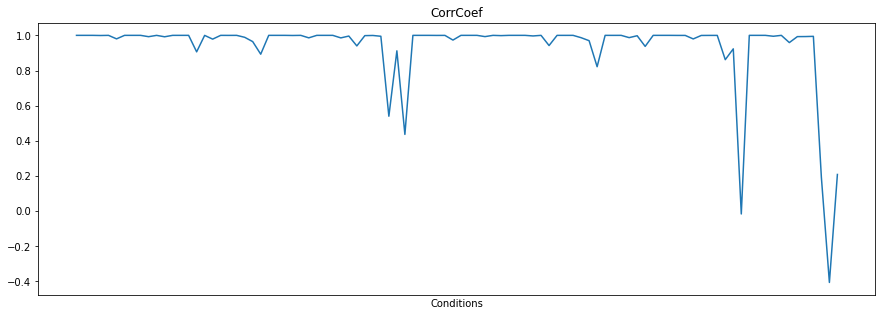

In [20]:
data_comp_df = pd.DataFrame.from_dict(data_comp_dict)
data_comp_df = data_comp_df.T

col_names = ['CorrCoef']
data_comp_df.columns = col_names



plt.figure(figsize=(15,5))
for img in range(data_comp_df.shape[1]):
    plt.subplot(data_comp_df.shape[1], 1, img+1)
    plt.plot(data_comp_df[col_names[img]])
    plt.xticks([])
    plt.xlabel('Conditions')
    plt.title(data_comp_df.columns[img])

In [24]:
data_comp_df[data_comp_df['CorrCoef'] < 0.95]

,CorrCoef
CarRotation.x_Westbrueck_segment_2,0.906249
CarRotation.z_Westbrueck_segment_3,0.892907
CarRotation.z_MountainRoad_segment_1,0.939935
CarRotation.x_MountainRoad_segment_2,0.539963
CarRotation.y_MountainRoad_segment_2,0.911965
CarRotation.z_MountainRoad_segment_2,0.436595
CarRotation.z_CountryRoad_segment_1,0.942027
CarRotation.z_CountryRoad_segment_2,0.821609
CarRotation.z_CountryRoad_segment_3,0.937222
CarRotation.x_Autobahn_segment_1,0.861766


In [22]:
data_comp_df[data_comp_df['CorrCoef'] > 0.95]

,CorrCoef
CarPosition.x_Westbrueck_segment_0,0.999999
CarPosition.y_Westbrueck_segment_0,0.999997
CarPosition.z_Westbrueck_segment_0,0.999999
CarRotation.x_Westbrueck_segment_0,0.999167
CarRotation.y_Westbrueck_segment_0,0.999959
...,...
CarRotation.y_Autobahn_segment_2,0.999945
CarRotation.z_Autobahn_segment_2,0.958893
CarPosition.x_Autobahn_segment_3,0.992809
CarPosition.y_Autobahn_segment_3,0.993156


In [26]:
reference_paths_all_events_failed

{'Westbrueck': {0:       CarPosition.x  CarPosition.y  CarPosition.z  LocalCarPosition.x  \
  0        537.009521     220.837051    1457.492310        -1003.746826   
  1        536.654846     220.825043    1457.283447        -1003.517822   
  2        536.477905     220.819054    1457.179382        -1003.403595   
  3        536.300964     220.813065    1457.075317        -1003.289368   
  4        536.124725     220.807121    1456.971558        -1003.175568   
  ...             ...            ...            ...                 ...   
  2453     298.086365     229.386765    1259.268188         -791.970093   
  2454     298.020966     229.390656    1259.217102         -791.915283   
  2455     297.955566     229.394547    1259.166016         -791.860474   
  2456     297.955566     229.394547    1259.166016         -791.860474   
  2457     297.823578     229.402420    1259.062988         -791.749939   
  
        LocalCarPosition.y  LocalCarPosition.z  CarRotation.x  CarRotation.y  \


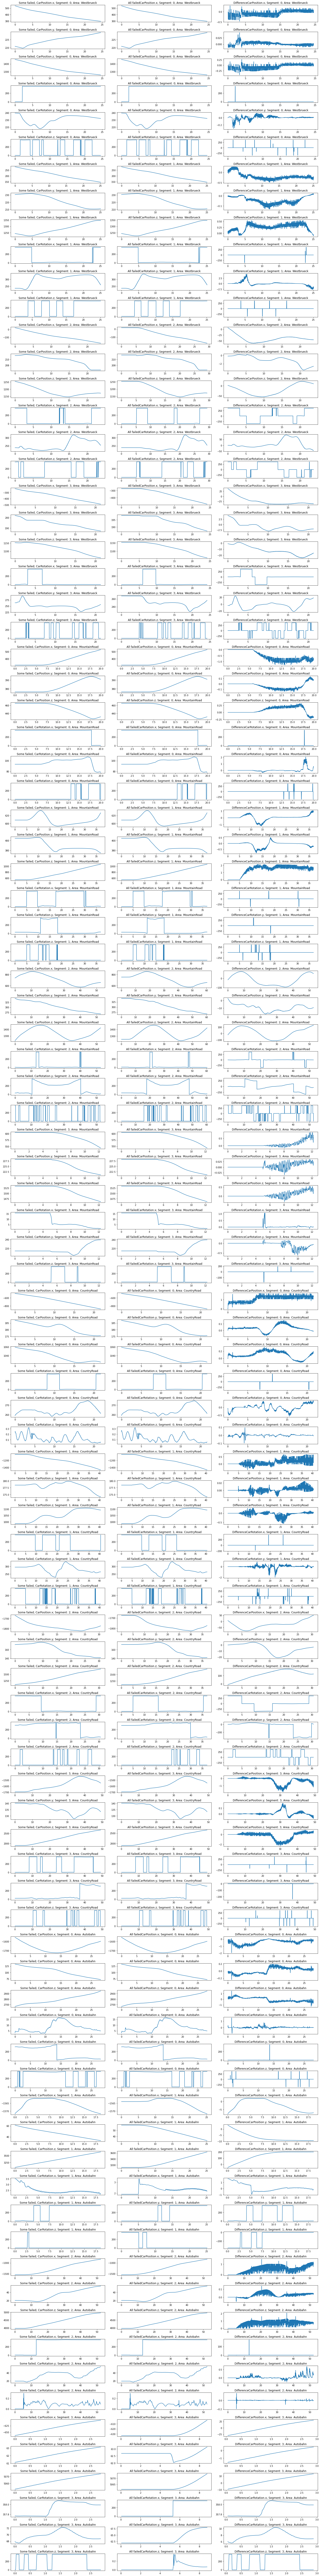

In [61]:
fig, axs = plt.subplots(nrows=96, ncols=3, figsize=(20,160))

car_data_names = ["CarPosition.x","CarPosition.y","CarPosition.z","CarRotation.x","CarRotation.y","CarRotation.z"]
areas = ["Westbrueck", "MountainRoad","CountryRoad","Autobahn"]
segments = [0,1,2,3]
ncols = 3

for idx, ax in enumerate(axs.reshape(-1)):
    
        
        car_data_idx = (idx // ncols) % len(car_data_names)
        segments_idx = (idx // (ncols * len(car_data_names)) ) % len(segments)
        area_idx = (idx // (ncols * len(car_data_names) * len(segments))) % len(areas)
        
        if (idx % 3 == 0):
            ax.plot(reference_paths_some_events_failed[areas[area_idx]][segments_idx]["resampled_timestamp"], \
                    reference_paths_some_events_failed[areas[area_idx]][segments_idx][car_data_names[car_data_idx]])
            ax.set_title("Some failed; " + car_data_names[car_data_idx] + "; Segment: " + str(segments[segments_idx]) + "; Area: " + areas[area_idx])
        elif (idx % 3 == 1):
            ax.plot(reference_paths_all_events_failed[areas[area_idx]][segments_idx]["resampled_timestamp"], \
                    reference_paths_all_events_failed[areas[area_idx]][segments_idx][car_data_names[car_data_idx]])
            ax.set_title("All failed" + car_data_names[car_data_idx] + "; Segment: " + str(segments[segments_idx]) + "; Area: " + areas[area_idx])
        else:
            y = 0 # determine longer column 
            if (len(reference_paths_some_events_failed[areas[area_idx]][segments_idx][car_data_names[car_data_idx]]) \
                > len(reference_paths_all_events_failed[areas[area_idx]][segments_idx][car_data_names[car_data_idx]])):
                x = reference_paths_some_events_failed[areas[area_idx]][segments_idx]["resampled_timestamp"]
            else:
                x = reference_paths_all_events_failed[areas[area_idx]][segments_idx]["resampled_timestamp"]
            ax.plot(x, reference_paths_some_events_failed[areas[area_idx]][segments_idx][car_data_names[car_data_idx]] \
                    - reference_paths_all_events_failed[areas[area_idx]][segments_idx][car_data_names[car_data_idx]])
            ax.set_title("Difference" + car_data_names[car_data_idx] + "; Segment: " + str(segments[segments_idx]) + "; Area: " + areas[area_idx])
                
        
fig.tight_layout()
plt.show()


